# V.1 Exploring the green reds

## a) Function that plots a scatterplot matrix

In [9]:
from matplotlib import scale
%load_ext Cython


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [10]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import random


random.seed(3)

In [11]:
red_wine_data = pd.read_csv('resources/winequality-red.csv', sep=';')
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [12]:
red_wine_data = pd.read_csv('resources/winequality-red.csv', sep=';')
# Dictionary with column names which have space in the name as a key and replaced spaces to _ as value
columns_to_replace = {name: name.replace(' ', '_') for name in red_wine_data.columns if ' ' in name}

# Replace dataFrame colum names with spaces to names with '_' for better usability
red_wine_data.rename(columns=columns_to_replace, inplace=True)
red_wine_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# V.1 Exploring the green reds

## a) Function that plots a scatterplot matrix

In [21]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    features = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'quality']
    features = wine_data.columns # Only for test
    features_amount = len(features) - 1
    
    data = wine_data[features]    
    good_wines = data[data['quality'] >= good_threshold]
    bad_wines = data[data['quality'] <= bad_threshold]    
    
    fig, axes = plt.subplots(nrows=features_amount, ncols=features_amount, figsize=(12,12))
    fig.subplots_adjust(hspace=0.0, wspace=0.0)

    for axis in axes.flat:
        # Hide all ticks and labels
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)

    for i in range(features_amount):
        for j in range(features_amount):
            if i == j:
                axes[i, j].annotate(good_wines.columns[i], (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
            else:
                axes[i, j].scatter(bad_wines.iloc[:, j], bad_wines.iloc[:, i], color='purple', marker='o', s=3)
                axes[i, j].scatter(good_wines.iloc[:, j], good_wines.iloc[:, i], color='green', marker='o', s=3) 
    plt.show()
    if save_plot:
        fig.savefig('figure.png')
#     return good_wines, bad_wines

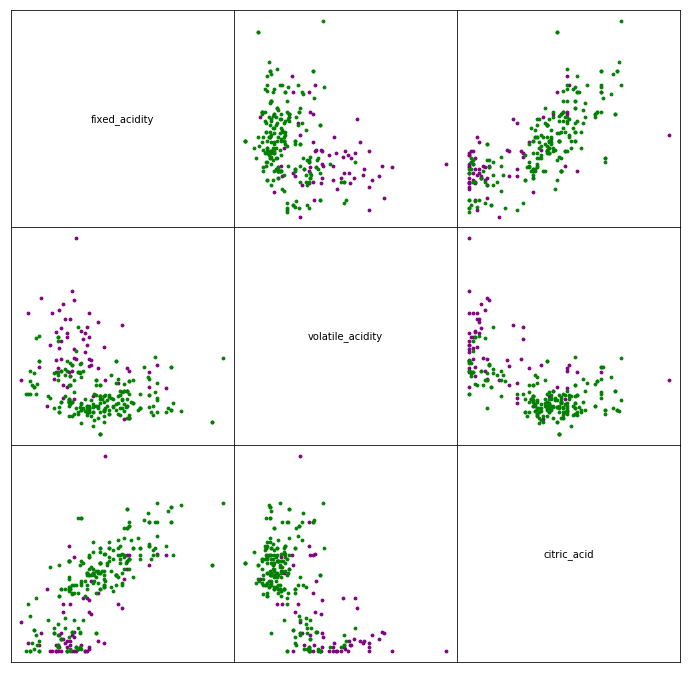

In [18]:
plot_scatter_matrix(red_wine_data, 7, 4)


### b)
###### As we can see from figures bellow there are two types of factors: from which we can separte wines for good and bad and from which can't.
###### So factors by which we can devide wines to two classes is:
    1) fixed acidity/volatile acidity
    2) fixed acidity/clorides
    3) volatile_acidity/clorides
    4) volatile_acidity/sulphates
    5) volatile_acidity/alcohol
    6) pH/alcohol
    7) sulphates/alcohol - looks like we can try
The main reasone why its good - we can lineary devide it to two classes - good and bad wines
###### Other factors we can't lineary devide to two classes.

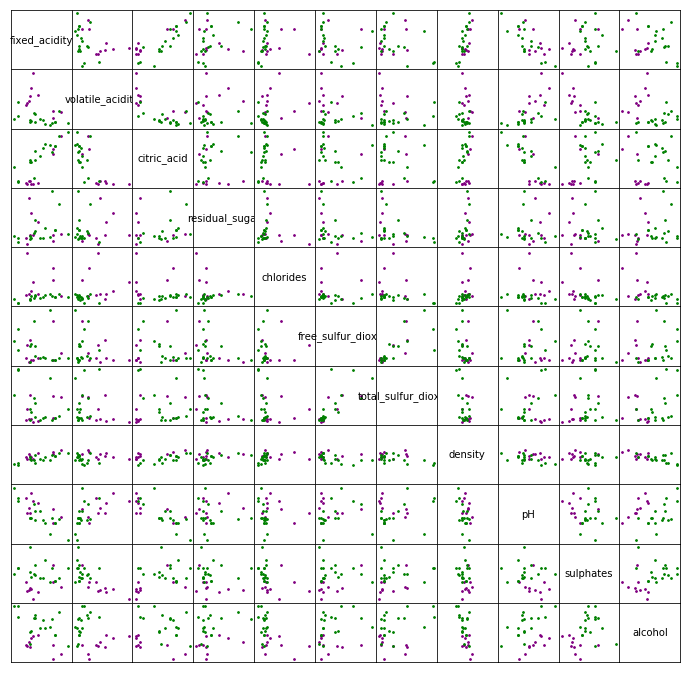

In [22]:
plot_scatter_matrix(red_wine_data, 8, 3)

# V.2 Learning to perceptron

## a) Implement a perceptron that:
    • Has randomly initialized weights and bias
    • Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
    • Utilizes the heaviside step activation function (discrete version)

In [15]:
class Perseptron:
    def __init__(self, learning_rate: float, n_epoch: int, dataset):
        # Has randomly initialized weights and bias
        self.weights = [random.gauss(1.0, 1.5) for i in range(len(dataset[0]))]
        self.learning_rate = learning_rate
        self.dataset = dataset
        self.n_epoch = n_epoch
        self.sum_error = 0.0
        self.correct_predictions = 0
        self.wrong_predictions = 0
        self.accuracy = 0.0
        self.current_epoch = 0
        self.training_statistics = list()
        self.error = 0.0
    
    @property
    def stop_training(self):
        if self.n_epoch == 0:
            return self.wrong_predictions == 0 and self.current_epoch > 0
        else:
            return self.current_epoch == self.n_epoch        

    def __predict(self, row):
        activation = self.weights[0]
        for i in range(len(row) - 1):
            activation += (self.weights[i + 1] * row[i])
        # Utilizes the heaviside step activation function (discrete version)
        return 1.0 if activation > 0.0 else 0.0
    
    def __calculate_weights(self):
        for row in self.dataset:
            prediction = self.__predict(row)
            if prediction == row[-1]:
                self.correct_predictions += 1
            error = row[-1] - prediction
            self.sum_error += error**2
            self.weights[0] += (self.learning_rate * error)
            for i in range(len(row) - 1):
                # Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
                self.weights[i + 1] += (self.learning_rate * error * row[i])
        self.accuracy = self.correct_predictions / len(self.dataset)
        self.wrong_predictions = len(self.dataset) - self.correct_predictions

    def __clean_statistics(self):
        self.accuracy = 0.0
        self.wrong_predictions = 0
        self.correct_predictions = 0
        self.sum_error = 0.0
    
    def train_perceptron(self):
        while True:
            if self.stop_training:
                break
            self.__clean_statistics()
            self.__calculate_weights()
            training_data = (self.current_epoch, self.wrong_predictions, self.weights[1:], self.weights[0], self.accuracy)
            self.training_statistics.append(training_data)
            self.current_epoch += 1
        return self.training_statistics

In [60]:
random.seed(3)

dataset = red_wine_data[(red_wine_data['quality'] >=8) | (red_wine_data['quality'] <= 3)]
dataset['y'] = dataset.apply(lambda data: 1.0 if data['quality'] >= 8 else 0.0, axis=1)
dataset = dataset[['alcohol', 'pH', 'y']]

p = Perseptron(0.01, 0, dataset.values)
result_data = p.train_perceptron()

/home/misha/UNIT/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


###### c) Write a function that will take the output of your perceptron training function and your red wine data and generate two plots in one figure:
    • The first plot should plot the number of errors your perceptron made as a function of epoch. Be careful with how you calculate errors!
    
    • The second plot should plot the decision boundary of your perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot should also shade ‘good’ and ‘bad’ areas!
    
    • Your function should allow the user to specify a specific epoch and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch.

In [61]:
def plot_perfomance(perfomance, wine_data, dood_tresh, bad_tresh, epoch=-1, save_plot=False):
    """
    Plot the perfomance of our perceptrone or adaline.
    This funcion will reproduce a two plot figure:
    1) Classification Errors vs. Epoch
    2) Decision boundary for two factors
    """
    dataset = wine_data[(wine_data['quality'] >=dood_tresh) | (wine_data['quality'] <= bad_tresh)]
    dataset['y'] = dataset.apply(lambda data: 1.0 if data['quality'] >= dood_tresh else 0.0, axis=1)
    dataset = dataset[['alcohol', 'pH', 'y']]
    
    good_wines = dataset[dataset['y'] == 1.0]
    bad_wines = dataset[dataset['y'] == 0.0]    
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    
    errors = [elem[1] for elem in perfomance]
    epochs = [elem[0] for elem in perfomance]

    if epoch < 0:
        epoch = epochs[-1]
    
    weights = perfomance[epoch][2]
    bias = perfomance[epoch][3]


    X = [elem for elem in range(0, 100)]
    Y = [(-1* bias - point * weights[0])/weights[1] for point in X]

    y_min = dataset['pH'].min() - dataset['pH'].min() * 0.01
    y_max = dataset['pH'].max() + dataset['pH'].max() * 0.01
    x_min = dataset['alcohol'].min() - dataset['alcohol'].min() * 0.02
    x_max = dataset['alcohol'].max() + dataset['alcohol'].max() * 0.02

    axes[0].plot(epochs, errors)
    axes[0].set_title('Errors as a function of epoch')
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('classification errors')
    
    axes[1].plot(good_wines['alcohol'], good_wines['pH'], color='green', markersize=10, marker='.', linestyle='none')
    axes[1].plot(bad_wines['alcohol'], bad_wines['pH'], color='red', markersize=10, marker='.', linestyle='none')
    axes[1].set_title(f'Descision boundary on epoch: {epoch}')
    axes[1].axis([x_min, x_max, y_min, y_max])
    axes[1].plot(X, Y, label="Decision Boundary", linestyle='dashed')
    axes[1].set_xlabel('alcohol')
    axes[1].set_ylabel('ph')
    axes[1].fill_between(X, Y, y_min, where=Y>y_min - 2, facecolor='green', alpha=.2)
    axes[1].fill_between(X, Y, y_max, where=Y<y_max + 2, facecolor='red', alpha=.2)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.show()

/home/misha/UNIT/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


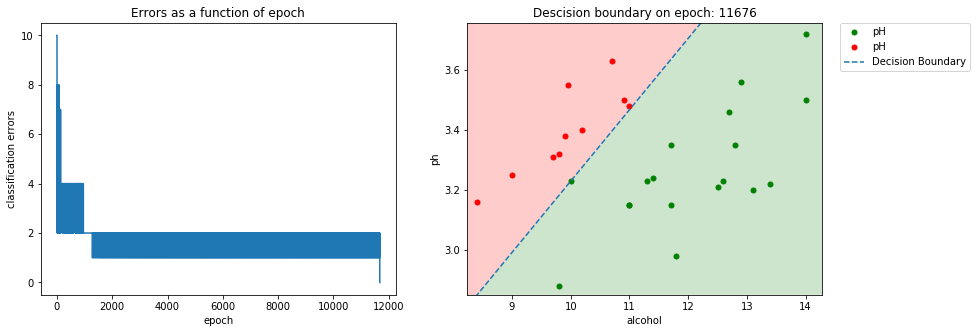

In [62]:
plot_perfomance(result_data, red_wine_data, 8, 3, epoch=-1232)
# red_wine_data.head()


###### d) Your perceptron appears to work. . . but why is it taking so many epochs to train?
    Maybe you can modify the red wine data to help the perceptron learn more quickly?
    Use the function you just created in part c) to plot and verify that your
    perceptron is learning more efficiently!

/home/misha/UNIT/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


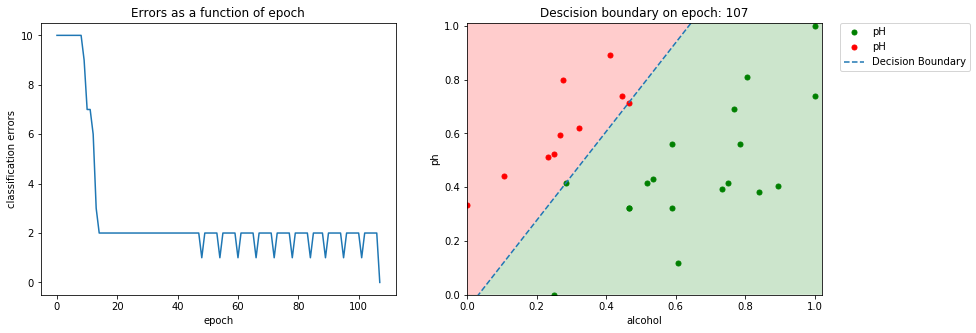

In [64]:
random.seed(3)

dataset = red_wine_data[(red_wine_data['quality'] >=8) | (red_wine_data['quality'] <= 3)]
quality_col = dataset['quality']
dataset['y'] = dataset.apply(lambda data: 1.0 if data['quality'] >= 8 else 0.0, axis=1)
dataset = dataset[['alcohol', 'pH', 'y']]

dataset = (dataset-dataset.min())/(dataset.max()-dataset.min())

p = Perseptron(0.01, 0, dataset.values)
result_data = p.train_perceptron()

dataset['quality'] = quality_col
plot_perfomance(result_data, dataset, 8, 3, epoch=-1)

/home/misha/UNIT/ml_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


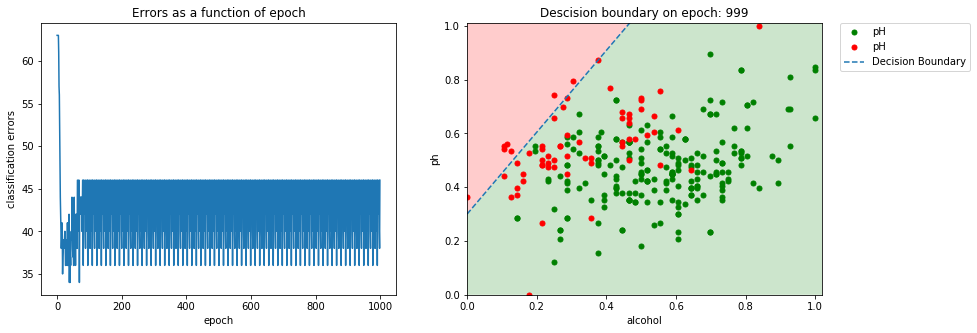

In [66]:

dataset = red_wine_data[(red_wine_data['quality'] >=7) | (red_wine_data['quality'] <= 4)]
quality_col = dataset['quality']
dataset['y'] = dataset.apply(lambda data: 1.0 if data['quality'] >= 7 else 0.0, axis=1)
dataset = dataset[['alcohol', 'pH', 'y']]

dataset = (dataset-dataset.min())/(dataset.max()-dataset.min())

p = Perseptron(0.01, 1000, dataset.values)
result_data = p.train_perceptron()

dataset['quality'] = quality_col
plot_perfomance(result_data, dataset, 7, 4, epoch=-1)

1.7250365716253988

#### b) You’ll need to implement a function to train your perceptron. Your training function should take in your red wine data as a parameter and should:
    • Have a way to specify number of training epochs
    • Train your perceptron until it makes no errors, if training epochs is set to 0,
    • Have a way to specify learning rate.
    • Return a list of python tuples containing (performance):
    
    [(current_epoch, num_errors_at_epoch_end, [array_of_weights], bias),...]

In [10]:
activation = sum(weight_i * x_i) + bias

NameError: name 'weight_i' is not defined

#### For the Perceptron algorithm, each iteration the weights (w) are updated using the equation:
w = w + learning_rate * (expected - predicted) * x

In [12]:
w = w + learning_rate * (expected - predicted) * x

NameError: name 'w' is not defined

##### There is one weight for each input attribute, and these are updated in a consistent way, for example:
w(t+1)= w(t) + learning_rate * (expected(t) - predicted(t)) * x(t)

##### The bias is updated in a similar way, except without an input as it is not associated with a specific input value:
bias(t+1) = bias(t) + learning_rate * (expected(t) - predicted(t))
